# Darknet

> Trying darknet on imagenet tiny.

Darknet19 is very simple backbone for image detection model, [yolov2](https://arxiv.org/pdf/1612.08242v1). To learn how image detections work with bounding boxes, this seems like a good place to start. 

In [ ]:
from minai import *

import torch
import torch.nn as nn
from datasets import load_dataset, load_dataset_builder
from torcheval.metrics import  MulticlassAccuracy
import torchvision.transforms.v2.functional as TF

In [ ]:
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt

import httpx

In [ ]:
set_seed(42)

## Data

We use imagenet tiny to test our darknet before moving on to the actual imagenet with 1000 classes. We will grab images from huggingface datasets.

In [ ]:
ds_name = 'zh-plus/tiny-imagenet'
dsd = load_dataset(ds_name)
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

Unfortunately, some images are gray images (1 channel) instead of colors (3 channels). We repeat channels to make it 3 channels. We also make the images to be scaled to between 0 and 1.

In [ ]:
def transforms(b):
    def process_image(img):
        tensor = TF.to_dtype(TF.to_image(img), dtype=torch.float32, scale=True)
        if tensor.shape[0] == 1: tensor = tensor.repeat(3, 1, 1) 
        return tensor
    
    b['image'] = [process_image(o) for o in b['image']]
    return b

In [ ]:
ds = dsd.with_transform(transforms)
dls = DataLoaders.from_dd(ds,batch_size=64)
xb, yb = next(iter(dls.train))
xb.shape, yb.shape, yb[:5]

(torch.Size([64, 3, 64, 64]),
 torch.Size([64]),
 tensor([ 82,  83, 124, 184, 169]))

In [ ]:
yb[:5]

tensor([ 82,  83, 124, 184, 169])

In [ ]:
lbls = np.array(ds['train'].features['label'].names)
lbls[:5]

array(['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640'],
      dtype='<U9')

So, the labels are not very distinguishable. Let's get the actual labels.

In [ ]:
import ast

res = httpx.get('https://huggingface.co/datasets/zh-plus/tiny-imagenet/raw/main/classes.py')
cls = ast.literal_eval(res.text.split('=')[1])
dict(list(cls.items())[:5])

{'n00001740': 'entity',
 'n00001930': 'physical entity',
 'n00002137': 'abstraction, abstract entity',
 'n00002452': 'thing',
 'n00002684': 'object, physical object'}

In [ ]:
def get_lbls(yb): return [cls[o].split(',')[0] for o in lbls[yb]]

In [ ]:
get_lbls(yb[:5])

['Christmas stocking', 'cliff dwelling', 'poncho', 'bee', 'ice lolly']

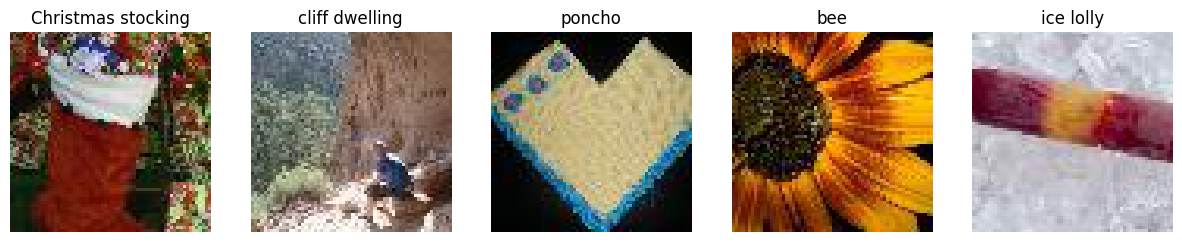

In [ ]:
show_images(xb[:5], ncols=5, titles=get_lbls(yb[:5]))

That looks about right.

## Basic model

Before using the darknet, I would like to use a simple model to get the training going.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 200, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(200),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten()
)

In [ ]:
cbs = [
    TrainCB(), # Handles the core steps in the training loop. Can be left out if using TrainLearner
    DeviceCB(), # Handles making sure data and model are on the right device
    MetricsCB(accuracy=MulticlassAccuracy()), # Keep track of any relevant metrics
    ProgressCB(), # Displays metrics and loss during training, optionally plot=True for a pretty graph
]

In [ ]:
loss_fn = nn.CrossEntropyLoss()
learn = Learner(model, dls, loss_fn, lr=10, cbs=cbs)
# learn.show_image_batch()

In [ ]:
# learn.summary()

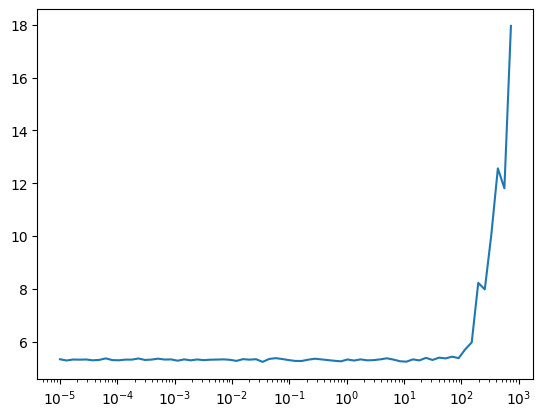

In [ ]:
learn.lr_find()

In [ ]:
learn.fit(10)

accuracy,loss,epoch,train,time
0.016,5.473,0,train,00:17
0.016,5.206,0,eval,00:01
0.030,5.137,1,train,00:17
0.026,5.159,1,eval,00:01
0.037,5.077,2,train,00:17
0.028,5.130,2,eval,00:01
0.043,5.031,3,train,00:17
0.037,5.083,3,eval,00:01
0.048,4.985,4,train,00:17
0.049,4.966,4,eval,00:01


Good. It trains. So, the dataloader is set properly. Let's move on to darknet.

## Darknet

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        padding = 1 if kernel_size == 3 else 0
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)

    def forward(self, x): return self.leaky(self.bn(self.conv(x)))

In [ ]:
class Darknet19(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # Initial layers
            ConvBlock(3, 32),
            nn.MaxPool2d(2),
            ConvBlock(32, 64),
            nn.MaxPool2d(2),
            
            # First block
            ConvBlock(64, 128),
            ConvBlock(128, 64, kernel_size=1),
            ConvBlock(64, 128),
            nn.MaxPool2d(2),
            
            # Second block
            ConvBlock(128, 256),
            ConvBlock(256, 128, kernel_size=1),
            ConvBlock(128, 256),
            nn.MaxPool2d(2),
            
            # Third block
            ConvBlock(256, 512),
            ConvBlock(512, 256, kernel_size=1),
            ConvBlock(256, 512),
            ConvBlock(512, 256, kernel_size=1),
            ConvBlock(256, 512),
            nn.MaxPool2d(2),
            
            # Fourth block
            ConvBlock(512, 1024),
            ConvBlock(1024, 512, kernel_size=1),
            ConvBlock(512, 1024),
            ConvBlock(1024, 512, kernel_size=1),
            ConvBlock(512, 1024)
        )

In [ ]:
model = nn.Sequential(
            # Initial layers
            ConvBlock(3, 32),
            nn.MaxPool2d(2),
            ConvBlock(32, 64),
            nn.MaxPool2d(2),
            
            # First block
            ConvBlock(64, 128),
            ConvBlock(128, 64, kernel_size=1),
            ConvBlock(64, 128),
            nn.MaxPool2d(2),
            
            # Second block
            ConvBlock(128, 256),
            ConvBlock(256, 128, kernel_size=1),
            ConvBlock(128, 256),
            nn.MaxPool2d(2),
            
            # Third block
            ConvBlock(256, 512),
            ConvBlock(512, 256, kernel_size=1),
            ConvBlock(256, 512),
            ConvBlock(512, 256, kernel_size=1),
            ConvBlock(256, 512),
            nn.MaxPool2d(2),
            
            # Fourth block
            ConvBlock(512, 1024),
            ConvBlock(1024, 512, kernel_size=1),
            ConvBlock(512, 1024),
            ConvBlock(1024, 512, kernel_size=1),
            ConvBlock(512, 1024),
    
            # Head
            ConvBlock(1024, 200, kernel_size=1),
#             nn.BatchNorm2d(200),
#             nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

In [ ]:
learn = Learner(model, dls, loss_fn, lr=10, cbs=cbs)
learn.summary()

Tot params: 20029976; MFLOPS: 224.6


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ConvBlock|(64, 3, 64, 64)|(64, 32, 64, 64)|960|3.5|
|MaxPool2d|(64, 32, 64, 64)|(64, 32, 32, 32)|0|0.0|
|ConvBlock|(64, 32, 32, 32)|(64, 64, 32, 32)|18624|18.9|
|MaxPool2d|(64, 64, 32, 32)|(64, 64, 16, 16)|0|0.0|
|ConvBlock|(64, 64, 16, 16)|(64, 128, 16, 16)|74112|18.9|
|ConvBlock|(64, 128, 16, 16)|(64, 64, 16, 16)|8384|2.1|
|ConvBlock|(64, 64, 16, 16)|(64, 128, 16, 16)|74112|18.9|
|MaxPool2d|(64, 128, 16, 16)|(64, 128, 8, 8)|0|0.0|
|ConvBlock|(64, 128, 8, 8)|(64, 256, 8, 8)|295680|18.9|
|ConvBlock|(64, 256, 8, 8)|(64, 128, 8, 8)|33152|2.1|
|ConvBlock|(64, 128, 8, 8)|(64, 256, 8, 8)|295680|18.9|
|MaxPool2d|(64, 256, 8, 8)|(64, 256, 4, 4)|0|0.0|
|ConvBlock|(64, 256, 4, 4)|(64, 512, 4, 4)|1181184|18.9|
|ConvBlock|(64, 512, 4, 4)|(64, 256, 4, 4)|131840|2.1|
|ConvBlock|(64, 256, 4, 4)|(64, 512, 4, 4)|1181184|18.9|
|ConvBlock|(64, 512, 4, 4)|(64, 256, 4, 4)|131840|2.1|
|ConvBlock|(64, 256, 4, 4)|(64, 512, 4, 4)|1181184|18.9|
|MaxPool2d|(64, 512, 4, 4)|(64, 512, 2, 2)|0|0.0|
|ConvBlock|(64, 512, 2, 2)|(64, 1024, 2, 2)|4721664|18.9|
|ConvBlock|(64, 1024, 2, 2)|(64, 512, 2, 2)|525824|2.1|
|ConvBlock|(64, 512, 2, 2)|(64, 1024, 2, 2)|4721664|18.9|
|ConvBlock|(64, 1024, 2, 2)|(64, 512, 2, 2)|525824|2.1|
|ConvBlock|(64, 512, 2, 2)|(64, 1024, 2, 2)|4721664|18.9|
|ConvBlock|(64, 1024, 2, 2)|(64, 200, 2, 2)|205400|0.8|
|AdaptiveAvgPool2d|(64, 200, 2, 2)|(64, 200, 1, 1)|0|0.0|
|Flatten|(64, 200, 1, 1)|(64, 200)|0|0.0|


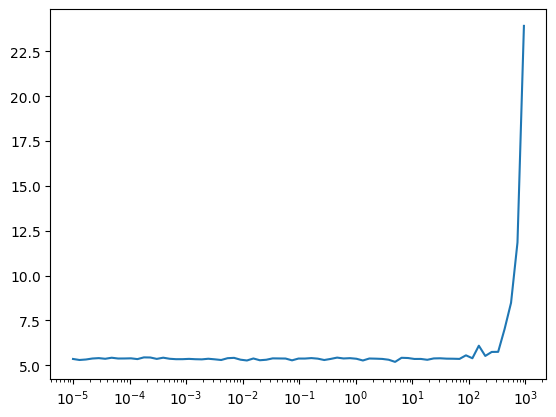

In [ ]:
learn.lr_find()

In [ ]:
learn.fit(10)

accuracy,loss,epoch,train,time
0.011,6.366,0,train,00:30
0.015,5.984,0,eval,00:01
0.017,5.914,1,train,00:30
0.021,5.806,1,eval,00:01
0.024,5.712,2,train,00:30
0.024,5.610,2,eval,00:01
0.029,5.541,3,train,00:30
0.032,5.425,3,eval,00:01
0.039,5.341,4,train,00:30
0.043,5.215,4,eval,00:01
